> 🚨 **WARNING** 🚨
>
> Many cells in this notebook will not show up when viewed on GitHub. Please view the HTML version of this notebook in the [docs](https://docs.rastervision.io/en/latest/usage/tutorials/index.html).

# Working with time-series of images

This notebook demonstrates how you can use time-series data with Raster Vision. We will query a STAC API for a spatiotemporal data cube and use a temporal model to run inference on it.

In particular, we will use a simple pre-trained model that computes attention scores for each image in the time-series. We will see that images with cloud cover get assigned lower attention scores.

## Install dependencies

In [5]:
!pip install osm2geojson==0.2.4 pystac_client==0.6.1 stackstac==0.4.3

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 21.7 MB/s eta 0:00:00
  Created wheel for osm2geojson: filename=osm2geojson-0.2.4-py3-none-any.whl size=13835 sha256=2ef691e12994c28c25abbad3d73790322c0c2bc71960f1d7323d4af1881caa76
  Stored in directory: /root/.cache/pip/wheels/10/ba/2d/a69a5c63066d23cf432ff909fa3db5950bdf389a360b07c0d4
Successfully built osm2geojson
  Attempting uninstall: pystac
    Found existing installation: pystac 1.6.1
    Uninstalling pystac-1.6.1:
      Successfully uninstalled pystac-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ras

---

In [67]:
from rastervision.core.box import Box
from rastervision.core.data import (RasterioCRSTransformer, StatsTransformer,
                                    XarraySource)
from rastervision.core.data.raster_source import XarraySource

from rastervision.core.data import Scene
from rastervision.pytorch_learner import (
    SemanticSegmentationRandomWindowGeoDataset)

import math
import torch

from matplotlib import pyplot as plt
import seaborn as sns
sns.reset_defaults()

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

---

## Get a time-series of Sentinel-2 images from a STAC API

Get Sentinel-2 imagery from 2023-06-01 to 2023-06-20 over Paris, France.

In [7]:
import pystac_client
import stackstac

In [ ]:
bbox = Box(ymin=48.8155755, xmin=2.224122, ymax=48.902156, xmax=2.4697602)
bbox_geometry = {'type': 'Polygon',
  'coordinates': (((2.224122, 48.8155755),
    (2.224122, 48.902156),
    (2.4697602, 48.902156),
    (2.4697602, 48.8155755),
    (2.224122, 48.8155755)),)}

In [9]:
URL = "https://earth-search.aws.element84.com/v1"
catalog = pystac_client.Client.open(URL)

items = catalog.search(
    intersects=bbox_geometry,
    collections=["sentinel-2-l2a"],
    datetime="2023-06-01/2023-06-20",
).get_all_items()

In [10]:
stack = stackstac.stack(items)
stack

<xarray.DataArray 'stackstac-90c28fee2fde381234a0e2a53fc2de3d' (time: 6,
                                                                band: 32,
                                                                y: 10980,
                                                                x: 10980)>
dask.array<fetch_raster_window, shape=(6, 32, 10980, 10980), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/52)
  * time                                     (time) datetime64[ns] 2023-06-02...
    id                                       (time) <U24 'S2B_31UDQ_20230602_...
  * band                                     (band) <U12 'aot' ... 'wvp-jp2'
  * x                                        (x) float64 4e+05 ... 5.098e+05
  * y                                        (y) float64 5.5e+06 ... 5.39e+06
    mgrs:grid_square                         <U2 'DQ'
    ...                                       ...
    title                                    (band) <U31 'Aerosol optical thi...
    gsd                                      (band) object None 10 ... None None
    common_name                              (band) object None 'blue' ... None
    center_wavelength                        (band) object None 0.49 ... None
    full_width_half_max                      (band) object None 0.098 ... None
    epsg                                     int64 32631
Attributes:
    spec:        RasterSpec(epsg=32631, bounds=(399960.0, 5390220.0, 509760.0...
    crs:         epsg:32631
    transform:   | 10.00, 0.00, 399960.00|\n| 0.00,-10.00, 5500020.00|\n| 0.0...
    resolution:  10.0

### Convert to a Raster Vision `RasterSource`

In [11]:
crs_transformer = RasterioCRSTransformer(
    transform=stack.transform, image_crs=stack.crs)

Subset the `DataArray` to the 12 Sentinel-2 bands in the order that the model expects.

In [64]:
data_array = stack
data_array = data_array.sel(
    band=[
        'coastal', # B01
        'blue', # B02
        'green', # B03
        'red', # B04
        'rededge1', # B05
        'rededge2', # B06
        'rededge3', # B07
        'nir', # B08
        'nir08', # B8A
        'nir09', # B09
        'swir16', # B11
        'swir22', # B12
    ])

### Create the `RasterSource`

In [62]:
raster_source_unnormalized = XarraySource(
    data_array,
    crs_transformer=crs_transformer,
    channel_order=list(range(len(data_array.band))),
    bbox=crs_transformer.map_to_pixel(Box(*bbox)).normalize(),
    temporal=True
)
raster_source_unnormalized.shape

(6, 947, 1810, 12)

The model expects unnormalized data, but we do need to normalize it if we want to visualize it. Below, we compute stats from the first 2 images in the sequence since they are free of clouds (this was determined by inspecting the images). We then use those stats to create a normalized version of the same `RasterSource` as above.

In [13]:
raster_source_stats = XarraySource(
    data_array.isel(time=[0, 1]),
    crs_transformer=crs_transformer,
    channel_order=list(range(len(data_array.band))),
    bbox=crs_transformer.map_to_pixel(Box(*bbox)).normalize(),
    temporal=True
)
stats_tf = StatsTransformer.from_raster_sources([raster_source_stats])

raster_source_viz = XarraySource(
    data_array,
    crs_transformer=crs_transformer,
    raster_transformers=[stats_tf],
    channel_order=list(range(len(data_array.band))),
    bbox=crs_transformer.map_to_pixel(Box(*bbox)).normalize(),
    temporal=True
)
raster_source_viz.shape

Analyzing chips: 0it [00:00, ?it/s]

(6, 947, 1810, 12)

Visualize the images in the time-series:

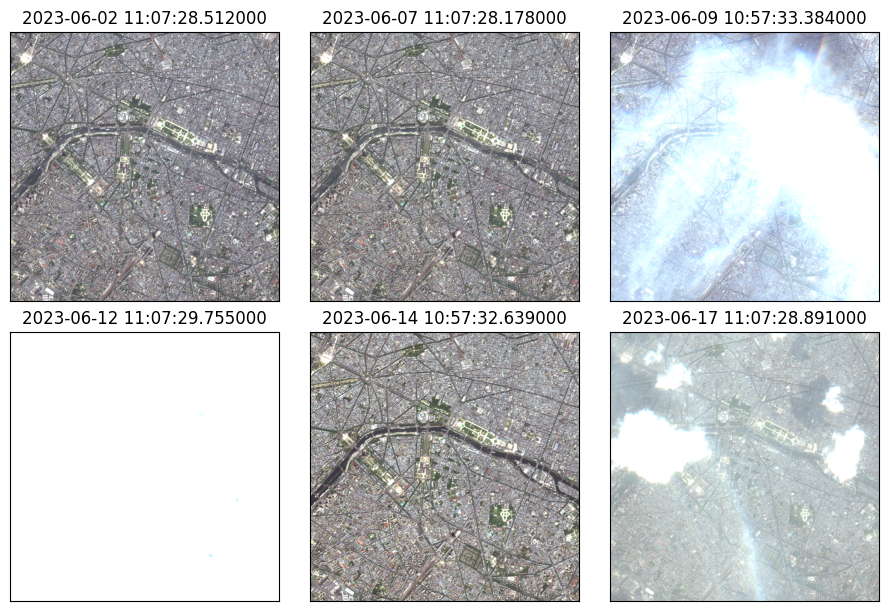

In [93]:
T = raster_source_viz.shape[0]
t_strs = raster_source_viz.data_array.time.to_series()

ncols = 3
nrows = int(math.ceil(T / ncols))
fig, axs = plt.subplots(
    nrows, ncols, figsize=(ncols * 3, nrows * 3), constrained_layout=True)
for t, t_str, ax in zip(range(T), t_strs, axs.flat):
    chip = raster_source_viz[t, 200:800, 400:1000, [3, 2, 1]]
    ax.imshow(chip)
    ax.set_title(t_str, fontsize=12)
    ax.tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False, labeltop=False)
plt.show()

---

## Get model

We will use a model from a fork of https://github.com/jamesmcclain/geospatial-time-series.

In [39]:
model_weights_path = 'https://s3.amazonaws.com/azavea-research-public-data/raster-vision/examples/tutorials-data/temporal/pretrained-resnet18-weights.pth'

In [69]:
model = torch.hub.load(
    'AdeelH/geospatial-time-series:rv-demo',
    'SeriesResNet18',
    source='github',
    trust_repo=False,
)
model.load_state_dict(
    torch.hub.load_state_dict_from_url(model_weights_path))
model = model.to(device=DEVICE)
model = model.eval()

The repository AdeelH_geospatial-time-series does not belong to the list of trusted repositories and as such cannot be downloaded. Do you trust this repository and wish to add it to the trusted list of repositories (y/N)? y


The repository is already trusted.


Using cache found in /root/.cache/torch/hub/AdeelH_geospatial-time-series_attn


---

## Run inference

Create a `RandomWindowGeoDataset` from the temporal `RasterSource`.

In [14]:
scene = Scene(id='test_scene', raster_source=raster_source_unnormalized)
ds = SemanticSegmentationRandomWindowGeoDataset(
    scene=scene, size_lims=(256, 256 + 1), out_size=256, return_window=True)

Sample a (temporal) chip:

In [73]:
(x, _), window = ds[0]
x.shape

torch.Size([6, 12, 256, 256])

For visualization, sample the same chip from the normalized `RasterSource`.

In [74]:
x_viz = raster_source_viz.get_chip(window, bands=[3, 2, 1])
x_viz.shape

(6, 256, 256, 3)

Get attention scores for each image in the series:

In [70]:
with torch.inference_mode():
    _x = x
    _x = _x.unsqueeze(0)
    _x = _x.to(device=DEVICE)
    out = model.embeddings_to_attention(model.forward_embeddings(_x))
    out = out.squeeze(-1)
out.shape

torch.Size([1, 6])

### Visualize model outputs

We can see that the model assigns lower scores to images with cloud cover, which makes intuitive sense.

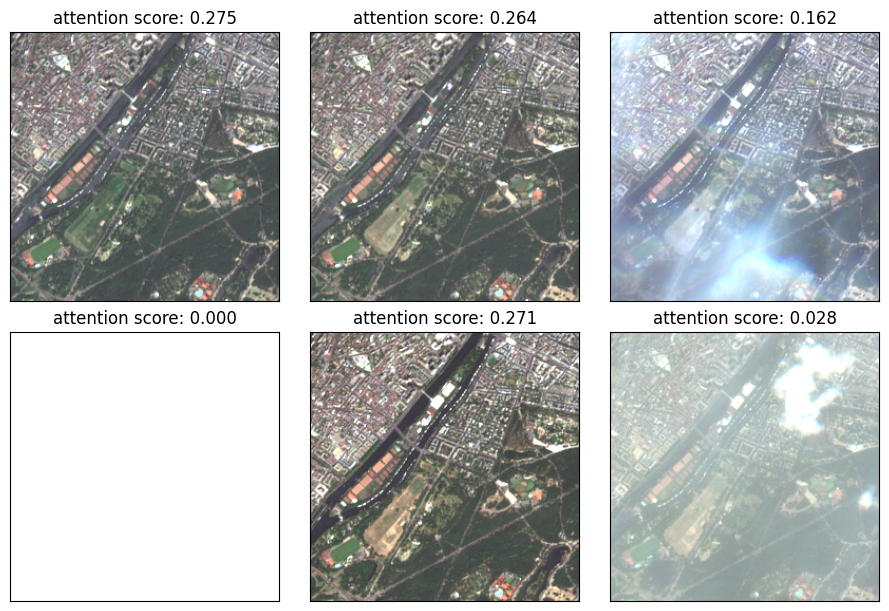

In [92]:
ncols = 3
nrows = int(math.ceil(T / ncols))
fig, axs = plt.subplots(
    nrows, ncols, figsize=(ncols * 3, nrows * 3), constrained_layout=True)
for ax, x_viz_t, attn_t in zip(axs.flat, x_viz, out[0]):
    ax.imshow(x_viz_t)
    ax.tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False, labeltop=False)
    ax.set_title(f'attention score: {attn_t:.3f}')
plt.show()